# DNA Nanodevice GNN Demo

This notebook demonstrates how to use the **G3NAT** (Graph Neural Network Nucleic Acid Transport) package to:
- Create DNA nanodevices as graph structures
- Predict transport properties (Density of States and Transmission) using pre-trained GNN models
- Visualize DNA graphs and compare predictions with theoretical calculations


## Part 0: Import Required Modules

Import all necessary libraries:
- **PyTorch Geometric**: For graph neural network operations
- **G3NAT modules**: Custom modules for DNA graph creation, GNN models, and visualization
- **Standard libraries**: NumPy, Matplotlib for data processing and plotting

In [10]:
# PyTorch modules
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch

# G3NAT Modules
from g3nat.graph import sequence_to_graph
from g3nat.data.synthetic import getTransmissionDOS
from g3nat.evaluation import load_trained_model, predict_sequence
from g3nat.visualization import visualize_dna_graph

# Other Python modules
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Graph Generation

### Creating a DNA Graph Structure

We'll create a test case with:
- **Primary strand**: `GGTCCCCCGC` (10 bases)
- **Complementary strand**: `__GGGGGA__` (underscores represent unpaired regions/tails)
- **Left contact**: Connected to positions 0 and 1 of the primary strand
- **Right contact**: Connected to positions 8 and 9 (last two bases) of the primary strand
- **Contact coupling strength**: 0.1 eV for both contacts

This represents a double-stranded DNA segment with single-stranded tails on both ends, connected to electrodes (contacts).

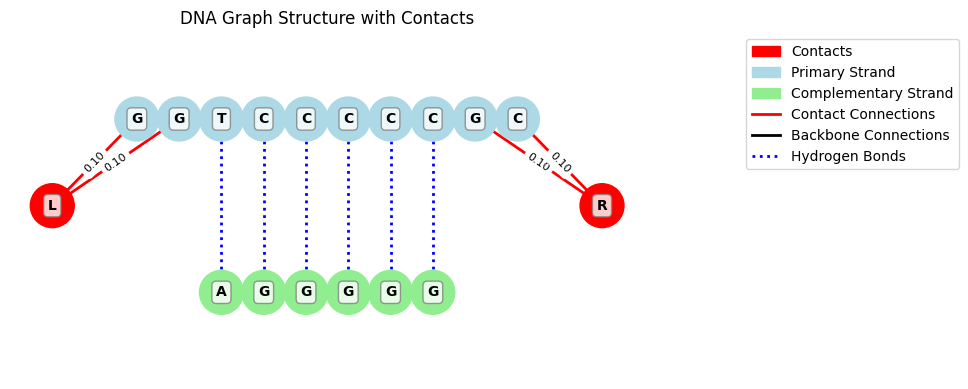


Graph Properties:
Number of nodes: 18
Number of DNA nodes: 16
Number of edges: 48

Full graph object:
Data(x=[18, 4], edge_index=[2, 48], edge_attr=[48, 5], num_dna_nodes=16)


In [11]:
# Define DNA sequence and structure
sequence = "GGTCCCCCGC"
complement = "__GGGGGA__"
contVal = 0.1  # Contact coupling strength in eV
lCont = [0, 1]  # Left contact positions (first two bases)
rCont = [len(sequence)-2, len(sequence)-1]  # Right contact positions (last two bases)
    
# Create the graph representation of the DNA structure
graph = sequence_to_graph(
    sequence,
    complement,
    left_contact_positions=lCont,
    right_contact_positions=rCont,
    left_contact_coupling=contVal,
    right_contact_coupling=contVal
)

# Visualize the graph structure
fig, ax = visualize_dna_graph(graph, sequence, complement, figsize=(10,4))
plt.title("DNA Graph Structure with Contacts")
plt.show()

# Display graph properties
print("\nGraph Properties:")
print(f"Number of nodes: {graph.num_nodes}")
print(f"Number of DNA nodes: {graph.num_dna_nodes}")
print(f"Number of edges: {graph.num_edges}")
print(f"\nFull graph object:")
print(graph)

### Calculate Transport Properties Using Tight-Binding Physics

Now we'll calculate the theoretical **Density of States (DOS)** and **Coherent Transmission** using a tight-binding Hamiltonian model combined with the Non-Equilibrium Green's Function (NEGF) formalism.

- **DOS**: Measures the number of electronic states available at each energy level
- **Transmission**: Measures the probability of an electron passing through the DNA from left to right contact
- **Energy grid**: We scan energies from -3 to +3 eV relative to the HOMO (Highest Occupied Molecular Orbital)

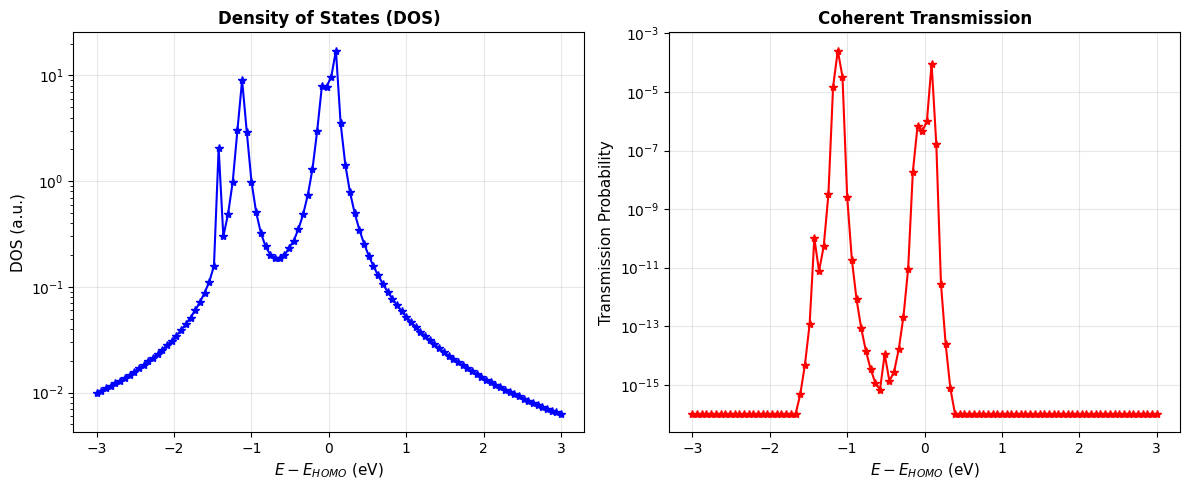

In [12]:
# Define energy grid for calculations
energy_grid = np.linspace(-3, 3, 100)

# Set up contact coupling matrices
gammaL = np.zeros(graph.num_dna_nodes)  # Left contact coupling
gammaL[lCont] = contVal

gammaR = np.zeros(graph.num_dna_nodes)  # Right contact coupling
gammaR[rCont] = contVal

# Calculate DOS and Transmission using tight-binding + NEGF
T, dos = getTransmissionDOS(sequence, complement, energy_grid, gammaL, gammaR)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.semilogy(energy_grid, dos, '*-', color='blue')
ax1.set_title('Density of States (DOS)', fontsize=12, fontweight='bold')
ax1.set_xlabel(r'$E - E_{HOMO}$ (eV)', fontsize=11)
ax1.set_ylabel('DOS (a.u.)', fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.semilogy(energy_grid, T, '*-', color='red')
ax2.set_title('Coherent Transmission', fontsize=12, fontweight='bold')
ax2.set_xlabel(r'$E - E_{HOMO}$ (eV)', fontsize=11)
ax2.set_ylabel('Transmission Probability', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: Using Pre-trained GNN Models

### Model 1: Standard GNN Architecture

This model uses a standard graph neural network architecture trained on 2000 samples of 4-10 base pair DNA sequences over 5000 epochs. It directly predicts DOS and transmission from the graph structure.

In [ ]:
# Load the standard pre-trained model
model, energy_grid, device = load_trained_model(
    "./trained_models/standard_2000x_4to10BP_5000epoch.pth"
)

# Predict DOS and transmission for our sequence
dos_pred, trans_pred = predict_sequence(
    model, 
    sequence, 
    complement,
    left_contact_positions=lCont,
    right_contact_positions=rCont, 
    left_contact_coupling=contVal,
    right_contact_coupling=contVal
)

# Plot predictions vs. theoretical calculations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# DOS comparison
ax1.semilogy(energy_grid, 10**dos_pred, '-k', linewidth=2, label='GNN Prediction')
ax1.semilogy(energy_grid, dos, ':r', linewidth=2, label='Tight-Binding Theory')
ax1.set_title('Density of States - Standard GNN', fontsize=12, fontweight='bold')
ax1.set_xlabel(r'$E - E_{HOMO}$ (eV)', fontsize=11)
ax1.set_ylabel('DOS (a.u.)', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Transmission comparison
ax2.semilogy(energy_grid, 10**trans_pred, '-k', linewidth=2, label='GNN Prediction')
ax2.semilogy(energy_grid, T, ':r', linewidth=2, label='Tight-Binding Theory')
ax2.set_title('Transmission - Standard GNN', fontsize=12, fontweight='bold')
ax2.set_xlabel(r'$E - E_{HOMO}$ (eV)', fontsize=11)
ax2.set_ylabel('Transmission Probability', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Model 2: Hamiltonian-Based GNN Architecture

This model learns to construct the Hamiltonian matrix directly from the graph structure, then uses NEGF formalism to compute DOS and transmission. This physics-informed approach can potentially generalize better by learning the underlying Hamiltonian representation.

In [ ]:
# Load the Hamiltonian-based pre-trained model
model, energy_grid, device = load_trained_model(
    "./trained_models/hamiltonian_2000x_4to10BP_5000epoch.pth"
)

# Predict DOS and transmission for our sequence
dos_pred, trans_pred = predict_sequence(
    model, 
    sequence, 
    complement,
    left_contact_positions=lCont,
    right_contact_positions=rCont, 
    left_contact_coupling=contVal,
    right_contact_coupling=contVal
)

# Plot predictions vs. theoretical calculations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# DOS comparison
ax1.semilogy(energy_grid, 10**dos_pred, '-k', linewidth=2, label='GNN Prediction')
ax1.semilogy(energy_grid, dos, ':r', linewidth=2, label='Tight-Binding Theory')
ax1.set_title('Density of States - Hamiltonian GNN', fontsize=12, fontweight='bold')
ax1.set_xlabel(r'$E - E_{HOMO}$ (eV)', fontsize=11)
ax1.set_ylabel('DOS (a.u.)', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Transmission comparison
ax2.semilogy(energy_grid, 10**trans_pred, '-k', linewidth=2, label='GNN Prediction')
ax2.semilogy(energy_grid, T, ':r', linewidth=2, label='Tight-Binding Theory')
ax2.set_title('Transmission - Hamiltonian GNN', fontsize=12, fontweight='bold')
ax2.set_xlabel(r'$E - E_{HOMO}$ (eV)', fontsize=11)
ax2.set_ylabel('Transmission Probability', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Analyzing the Learned Hamiltonian

The Hamiltonian-based model learns to construct a Hamiltonian matrix that captures the electronic structure of the DNA. Let's visualize this learned Hamiltonian and examine its properties.

C:\Users\trollium\AppData\Local\Temp\ipykernel_29136\2817745607.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.matshow(np.abs(model.H[0]), cmap='viridis')
C:\Users\trollium\AppData\Local\Temp\ipykernel_29136\2817745607.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 800x700 with 0 Axes>

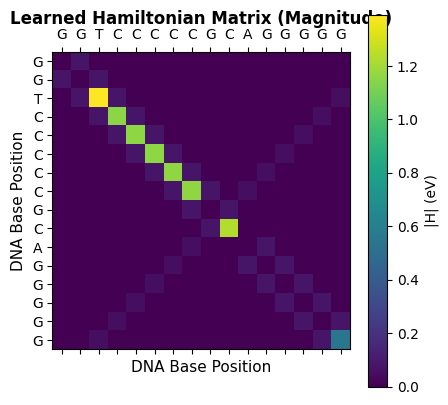

In [15]:
# Visualize the learned Hamiltonian matrix
plt.figure(figsize=(8, 7))
plt.matshow(np.abs(model.H[0]), cmap='viridis')
plt.colorbar(label='|H| (eV)')
plt.title('Learned Hamiltonian Matrix (Magnitude)', fontsize=12, fontweight='bold', pad=20)

# Label axes with DNA sequence
strand = sequence + complement.replace('_', '')[::-1]
plt.xticks(np.arange(len(strand)), list(strand), fontsize=10)
plt.yticks(np.arange(len(strand)), list(strand), fontsize=10)
plt.xlabel('DNA Base Position', fontsize=11)
plt.ylabel('DNA Base Position', fontsize=11)

plt.tight_layout()
plt.show()

### DNA Base Analysis

Let's analyze the composition of nucleotides in our full DNA structure (both strands) and check to see how well the onsite energies match up with the tight binding hamiltonian used for training:

In [16]:
# Construct full strand (primary + reverse complement)
strand = sequence + complement.replace('_', '')[::-1]
print("Base Composition:")
print("-" * 20)

diagonal_H_energies = torch.diag(model.H[0]).detach().numpy() # Get diagonal energies as numpy array
expected_energies = {'A': -0.49, 'T':-1.39, 'G': 0.00, 'C':-1.12}

for base in 'GCTA':
    # Correctly get indices of the current base in the strand
    base_indices = [i for i, char in enumerate(strand) if char == base]
    count = len(base_indices) # Count is simply the length of base_indices
    percentage = (count / len(strand)) * 100

    if count > 0:
        # Get the on-site energies from the Hamiltonian diagonal corresponding to these bases
        corresponding_energies = diagonal_H_energies[base_indices]
        average_energy = np.mean(corresponding_energies)
        print(f"{base} : {count:2d} ({percentage:5.1f}%) Average Energy: {average_energy:.2f}, Expected Energy: {expected_energies[base]:.2f}")
    else:
        # Handle case where base is not present
        print(f"{base} : {count:2d} ({percentage:5.1f}%) Average Energy: N/A")

print(f"\nTotal bases: {len(strand)}")
print(f"Full strand: {strand}")

Base Composition:
--------------------
G :  8 ( 50.0%) Average Energy: -0.07, Expected Energy: 0.00
C :  6 ( 37.5%) Average Energy: -1.17, Expected Energy: -1.12
T :  1 (  6.2%) Average Energy: -1.39, Expected Energy: -1.39
A :  1 (  6.2%) Average Energy: -0.00, Expected Energy: -0.49

Total bases: 16
Full strand: GGTCCCCCGCAGGGGG


---
## Summary

This notebook demonstrated:

1. **Graph Construction**: Converting DNA sequences into graph representations suitable for GNN processing
2. **Physics Calculations**: Computing theoretical DOS and transmission using tight-binding + NEGF
3. **GNN Predictions**: Using two types of pre-trained models:
   - Standard GNN: Direct prediction of transport properties
   - Hamiltonian GNN: Physics-informed approach learning the Hamiltonian matrix
4. **Analysis**: Examining the learned Hamiltonian and its properties

### Next Steps

- Try different DNA sequences and contact configurations
- Train your own models using `train.py`
- Explore the effect of sequence length and composition on transport properties

For more information, visit the [G3NAT GitHub repository](https://github.com/wliverno/G3NAT).